# Example: Linear Graph Dynamics - Part 1/2

- Author: Dr. Daning Huang
- Date: 08/07/2025
- Updated: 12/08/2025

## Introduction

In the previous examples, we have explored generic dynamical systems, with or without inputs.  Here, we take an initial exploration of the graph case.

The dynamical systems on graphs that we consider are of the following:

- Think vortices in fluids or electrical devices in power grids, each vortex/device (i.e., nodes) has some states.
- The interations are "nearly" local: The rate of change in states at one node is influenced by only the states of neighboring nodes; distant nodes barely have interactions.

To learn this type of dynamics from data, intuitively one would want to exclude terms that are associated with non-existent (distant) interactions.  This is where the graph comes in: it tells the model where the interaction exists, so that the model only learns what needs to be learnt.

Using graphs appropriately can be beneficial, including but not limited to: improved accuracy, faster convergence, fewer samples, preserved symmetry, etc.

That said, the goal of this example is to show the API of DyMAD to learn graph dynamics by a graph neural network (GNN).  So the example itself will be kept simple - and then one shall see that the procedure is nearly identical to the non-graph cases in the previous examples.

### Available Graph Models

In DyMAD, the GNN's are used in two ways: as autoencoder, and as dynamics.

- As autoencoder:
  + GNN first encodes the states and inputs at each node $(x_i,u_i)$ to latent space $z_i$, and the latent states per node $z_i$ are concatenated to produce the full latent states $z$; in this process, $z_i$ can depend on the states and inputs from neighboring nodes.
  + An arbitrary dynamics model can be applied to evolve $z_i$ - LDM, KBF, Kernel machine, etc., either continuous-time or discrete-time; here, the evolution is independent of other nodes.
  + Lastly, given new latent states $z'$, GNN decodes the latent states per node $z_i'$ to the new states per node $x_i'$; again, $x_i'$ can depend on latent states from neighboring nodes.
  + This type of models are denoted `GXXX`, such as `GLDM` is GNN autoencoder paired with `LDM` dynamics.

- As dynamics:
  + An arbitrary autoencoder model encodes $(x_i,u_i)$ to latent space $z_i$; this operation is node-wise and independent of other nodes.
  + GNN evolves the latent states $z_i$ per node, and may be impacted (only) by the neighboring nodes.
  + The autoencoder model decodes new latent states $z_i'$ to new states $x_i'$, which again is node-wise and independent of other nodes.
  + This type of models are denoted `XXXG`, such as `LDMG` is MLP autoencoder paired with GNN dynamics.

### In This Example

- Part 1 (this page) considers a `GKBF` model, and apply to an extremely simple example (fixed topology).  This is to show the procedure of GNN modeling in DyMAD.
- Part 2 will consider a `LDMG` model, and apply to a slightly more complex example with time-varying topologies.  This is to illustrate one example where GNN is a natural fit and other methods are inconvenient.

## Problem Setup

We will consider the LTI system used before

$$
\begin{align*}
\dot{z} &= \begin{bmatrix} 0 & 1 \\ -1 & -0.1 \end{bmatrix}z + \begin{bmatrix} 1 \\ 1 \end{bmatrix}u \equiv Az+Bu \\
x &= z
\end{align*}
$$

and concatenate three of the same systems as

$$
\begin{align*}
\dot{z}_i &= Az_i+Bu_i,\quad i=1,2,3 \\
x_i &= z_i
\end{align*}
$$

There can be two ways to represent this dynamics:

- "Naive" approach: Take $x=[x_1,x_2,x_3]$ and $u=[u_1,u_2,u_3]$ as distinct features, and learn a generic dynamics $\dot{x}=f(x,u)$.
- Graph approach: Still take $x$ and $u$ as features, but learn a node-wise dynamics $\dot{x}_i=f(x_i,u_i)$, so that $f$ is shared among the three sets of states.

Next we will take the second approach.

## Preparations

As usual the imports.  The new items are noted in the comments.

The imports:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from dymad.io import load_model
from dymad.models import GKBF, KBF          # G for graph.  There are also, e.g., LDM vs GLDM
from dymad.training import WeakFormTrainer  # The use of NODETrainer would be the same
from dymad.utils import adj_to_edge         # New in this example, will be used later
from dymad.utils import plot_summary, plot_trajectory, TrajectorySampler

Prepare the data.  The LTI system per node:

In [2]:
B = 32
N = 501
t_grid = np.linspace(0, 5, N)

A = np.array([
            [0., 1.],
            [-1., -0.1]])
def f(t, x, u):
    return (x @ A.T) + u
g = lambda t, x, u: x

config_chr = {
    "control" : {
        "kind": "chirp",
        "params": {
            "t1": 4.0,
            "dim": 3,
            "freq_range": (0.5, 2.0),
            "amp_range": (0.5, 1.0),
            "phase_range": (0.0, 360.0)}}}

A new quantity: adjacency matrix of the graph.  This matrix represents the relation among the nodes.  The particular choice below assumes equal contributions among the three nodes.

> Practically, this is the only new information to be added for GNN modeling.

In [3]:
adj = np.array([
    [0, 1, 1],
    [1, 0, 1],
    [1, 1, 0]
])

Then generate the samples.  Since every node is the same, we sample trajectories of one node, and then replicate twice.

In [4]:
sampler = TrajectorySampler(f, g, config='ltg_data.yaml', config_mod=config_chr)
ts, xs, us, ys = sampler.sample(t_grid, batch=B)
# Pretending a 3-node graph
np.savez_compressed(
    './data/ltg.npz',
    t=ts, x=np.concatenate([ys, ys, ys], axis=-1), u=np.concatenate([us, us, us], axis=-1),
    adj=adj)

## Training

The config file is as follows.  The only new option you would notice is `gcl` under `model`, which specifies the type of Graph Convolutional Layer.

Here we would not train for too many epochs, so as to highlight the differences between GKBF and KBF.

In [ ]:
"""
data:
  path: './data/ltg.npz'
  n_samples: 32
  n_steps: 501
  double_precision: true

transform_x:
  type: "identity"

transform_u:
  type: "identity"

split:
  train_frac: 0.75

dataloader:
  batch_size: 4

model:
  name: 'ltg_kbf_wf'
  encoder_layers: 1
  decoder_layers: 1
  hidden_dimension: 32
  koopman_dimension: 4
  const_term: true
  autoencoder_type: "smp"
  gcl: "sage"
  activation: "none"
  weight_init: "xavier_uniform"
  input_order: "cubic"

criterion:
  dynamics:
    weight: 1.0
  recon:
    weight: 1.0

training:
  n_epochs: 200
  save_interval: 20
  load_checkpoint: false
  learning_rate: 1e-2
  reconstruction_weight: 1.0
  dynamics_weight: 1.0 
  weak_form_params:
    N: 13
    dN: 2
    ordpol: 2
    ordint: 2
"""

Then the training of graph KBF (GKBF) model.  Note it is **identical** to a regular model training.

In [6]:
config_path = 'ltg_kbf_wf.yaml'
trainer = WeakFormTrainer(config_path, GKBF)
trainer.train();

Maybe not surprising, a regular KBF model can be trained using nearly the same setup - we just modify the model name.

But we will not show the results here to keep the example compact.

> The graph specific option `gcl` is ignored in KBF.

In [ ]:
"""
config_mod = {
    "model" : {
        "name" : 'ltg_kbf_ng',
        }
}
trainer = WeakFormTrainer(config_path, KBF, config_mod=config_mod)
trainer.train()
"""

## Results

The convergence plots as a rule of thumb:

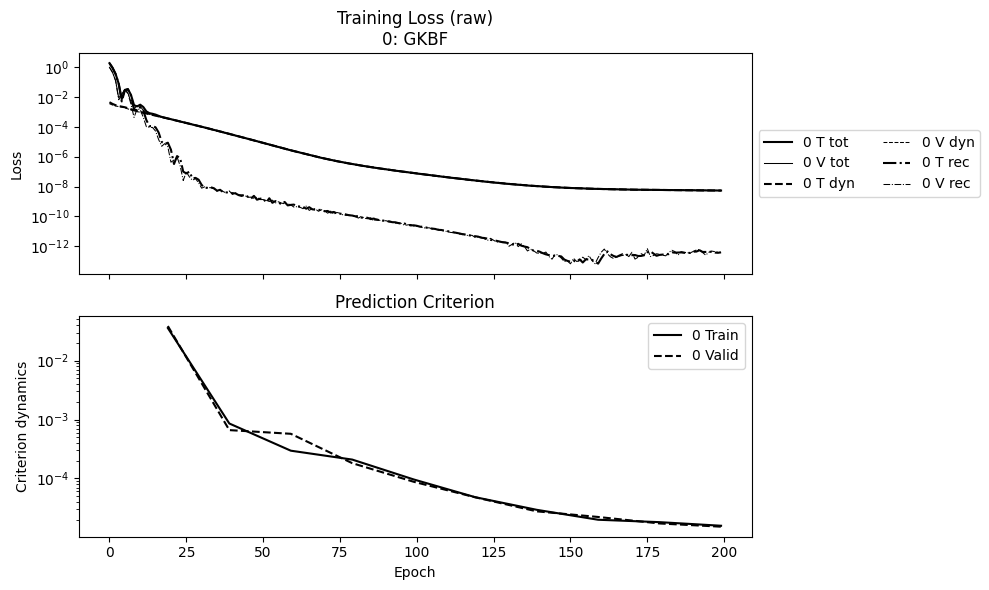

In [8]:
npz_file = ['ltg_kbf_wf']
npzs = plot_summary(npz_file, labels = ['GKBF'], ifscl=False, ifclose=False)

Comparing the prediction, within 200 epochs, GKBF is already able to capture the dynamics fairly well, and more importantly, the three sets of states are identical with the same inputs.

> `edge_index` is the only new information to be provided.

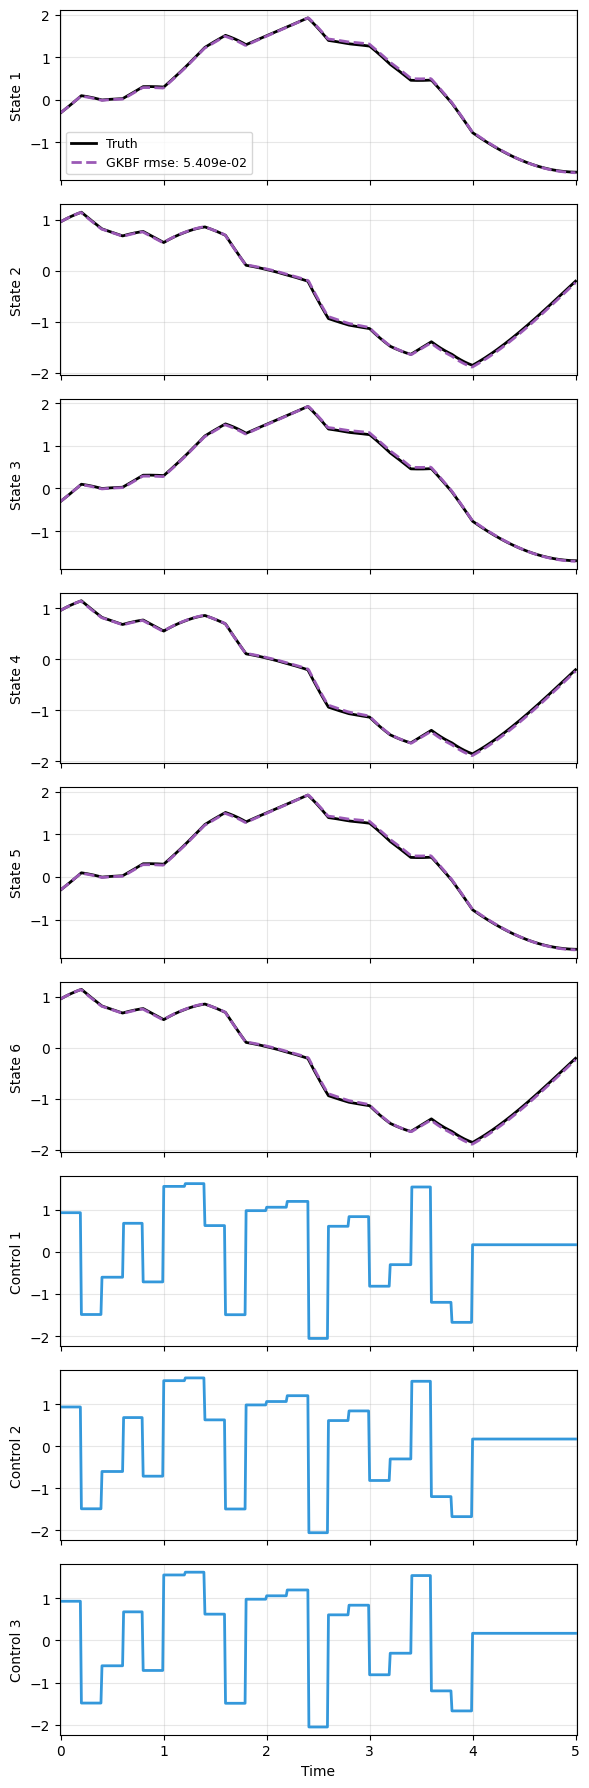

In [9]:
config_gau = {
    "control" : {
        "kind": "gaussian",
        "params": {
            "mean": 0.5,
            "std":  1.0,
            "t1":   4.0,
            "dt":   0.2,
            "mode": "zoh"}}}
sampler = TrajectorySampler(f, g, config='ltg_data.yaml', config_mod=config_gau)
edge_index = adj_to_edge(adj)[0]

ts, xs, us, ys = sampler.sample(t_grid, batch=1)
x_data = np.concatenate([ys[0], ys[0], ys[0]], axis=-1)
t_data = ts[0]
u_data = np.concatenate([us[0], us[0], us[0]], axis=-1)

_, prd_g = load_model(GKBF, 'ltg_kbf_wf.pt')

with torch.no_grad():
    g_pred = prd_g(x_data, t_data, u=u_data, ei=edge_index)

plot_trajectory(
    np.array([x_data, g_pred]), t_data, "LTG",
    us=u_data, labels=['Truth', 'GKBF'], ifclose=False);